# ITP Plot using Python

In [1]:
from itp_python.itp_query import ItpQuery
from datetime import datetime
from math import *
import numpy as np
import matplotlib.tri as tri
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# Subroutines 

cpsner : compute distance between 2 points

In [2]:
def cpsner(alat,alon,clat,clon):
# ================================================================
#                                              M.NAGATA <-- M.UENO
#                                         2006.06: R.Sakai for f90
#    ------------------------------------------------------------+
#    +< OUTPUT >                                                 +
#    +   RTG :  DISTANCE ALONG GREAT CIRCLE                      +
#    +          BETWEEN <A> AND <C>                              +
#    +   ANG :  ANGLE   SHOWN IN THE SCHEMATIC DIAGRAM           +
#    +                        (N)                                +
#    +                         !                                 +
#    +        270 < ANG < 360  !   180 < ANG < 270               +
#    +                         !                                 +
#    +    ------------------- (C) -----------------------        +
#    +                         !                                 +
#    +          0 < ANG <  90  !    90 < ANG < 180               +
#    +                         !                                 +
#    +                        (S)                                +
#    +< INPUT >                                                  +
#    +  ALON :  LONGITUDE OF <A>                                 +
#    +  ALAT :  LATITUDE  OF <A>                                 +
#    +  CLON :  LONGITUDE OF <C>                                 +
#    +  CLAT :  LATITUDE  OF <C>                                 +
#    +-----------------------------------------------------------+
#
  PI=asin(1.0E0)*2

  r0=6371E+3
  rad=asin(1.0E0)/90.0E0
  deg=1.0E0/float(rad)
  x1=float(clon)*float(rad)
  y1=float(clat)*float(rad)
  y1c=cos(y1)
  y1s=sin(y1)

  x2=float(alon)*rad
  y2=float(alat)*rad
  y2c=cos(y2)
  y2s=sin(y2)
  xd=x2-x1
  zc=y2c*y1c*cos(float(xd))+y2s*y1s
  zc=min([1.0E0,zc])
  zc=max([-1.0E0,zc])
  z=acos(float(zc))
  zs=sin(float(z))
  rtg=z*r0
  xd=(xd*deg+360.0E0) % 360.0E0
  if float(xd) != 0:
    alpha=(y2s-y1s*zc)/(y1c*zs)
    alpha=min([1.0E0,alpha])
    alpha=max([-1.0E0,alpha])
    alpha=acos(alpha)*deg
    if xd > 180.0E0:
       if alpha < 90.0E0:
          ang=float(alpha)+270.0E0
       if alpha >= 90.0E0:
          ang=alpha-90.0E0
    else:
      ang=270.0E0-alpha
  else:
    ang=90.0E0
    if y2 > y1 :
      ang=270.0E0
  return rtg,ang


sw_dpth : compute depth from pressure and latitude

In [3]:
def sw_dpth(p,lat):
    PI=asin(1.0E0)*2

    deg2rad = PI/180.0
    c1 = 9.72659
    c2 = -2.2512E-5
    c3 = 2.279E-10
    c4 = -1.82E-15
    gam_dash = 2.184e-6
    lat2 = abs(lat)
    x = sin(lat2*deg2rad) # convert to radians
    x = x*x
    bot_line = 9.780318*(1.0+(5.2788E-3+2.36E-5*x)*x) + gam_dash*0.5*p
    top_line = (((c4*p+c3)*p+c2)*p+c1)*p
    depth = top_line/bot_line
    return depth

# Main 

Read Data

In [4]:
path = "/Users/hiroyukimurakami/jupyter-notebook/itp_2019_12_13.db"

startTime = datetime(2010, 1, 1)
endTime = datetime(2010, 12, 31)

# Create an ItpQuery object and load arguments through the constructor
query = ItpQuery(path, latitude=[70, 80], longitude=[-170, -140], date_time=[startTime, endTime])

# Call fetch to retrieve results
results = query.fetch()
print('{} results returned'.format(len(results)))

1539 results returned


Compute accumulated distanse from starting point

In [5]:
nsect = len(results)
cumDistVec_track = np.zeros(nsect)
system_nums = np.zeros(nsect)

for ii, p in enumerate(results):
    system_nums[ii] = p.system_number
    if ii==0:
        lon0 = p.longitude
        lat0 = p.latitude
        cumDistVec_track[ii] = 0
        continue
    else:
        lon1 = p.longitude
        lat1 = p.latitude
        dist_, ang_ = cpsner(lat1,lon1,lat0,lon0)
        dist_ = dist_ / 1000.0 # m -> km
        cumDistVec_track[ii] = cumDistVec_track[ii-1] + dist_
        lon0 = lon1
        lat0 = lat1
    #print (ii,lon1,lat1,dist_from_orig[ii])
print ("min dist=",cumDistVec_track.min(), "maxx dist=",cumDistVec_track.max())

min dist= 0.0 maxx dist= 8756.161317343547


Reading variables

In [6]:
saltVec = []
tempVec = []
depthVec = []
cumDistVec = []

for ii, p in enumerate(results):
    saltVec.extend(p.salinity.flatten())
    tempVec.extend(p.temperature.flatten())
    dep = sw_dpth(p.pressure,p.latitude)
    depthVec.extend(dep.flatten())
    cumDistVec.extend(np.repeat(cumDistVec_track[ii], len(dep)))
    
saltVec = np.array(saltVec)
tempVec = np.array(tempVec)
depthVec = np.array(depthVec)
cumDistVec = np.array(cumDistVec)

Define Interpolated Grids

In [7]:
jmax = 100 # number of interpolated grids [x]
imax = 100 # number of interpolated grids [y]
depth = [10,800] # depth to draw 10m to 500m

dist = [0,cumDistVec[-1]]
distVec = np.linspace(dist[0],dist[1],imax)
depthRange = np.linspace(depth[0],depth[1],jmax)
xi, yi = np.meshgrid(distVec, depthRange)

Interpolate Salinity

In [8]:
salt = griddata((cumDistVec,depthVec),saltVec,(xi.reshape(imax*jmax), yi.reshape(imax*jmax)),method='linear')
salt = salt.reshape(imax,jmax)

Interpolate Temperature

In [9]:
temp = griddata((cumDistVec,depthVec),tempVec,(xi.reshape(imax*jmax), yi.reshape(imax*jmax)),method='linear')
temp = temp.reshape(imax,jmax)

Redefine interpolated grids

In [10]:
xi = xi.reshape(imax,jmax)
yi = yi.reshape(imax,jmax)

/Users/hiroyukimurakami/.conda/envs/mypy3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """


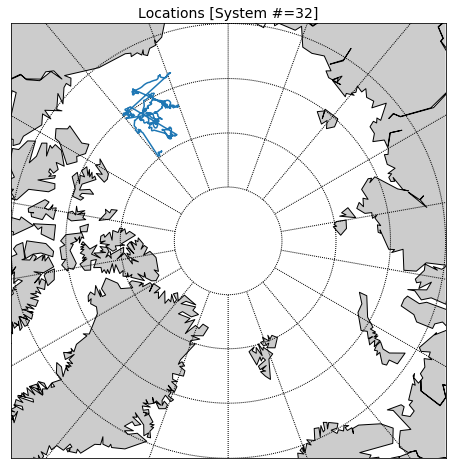

In [11]:
fig, ax1, = plt.subplots(nrows=1, figsize=(8,8))

longitude = [p.longitude for p in results]
latitude = [p.latitude for p in results]
m = Basemap(projection='npstere', boundinglat=70, lon_0=0, resolution='c')
m.drawcoastlines()
m.fillcontinents()
m.drawparallels(range(70, 90, 5))
m.drawmeridians(range(-180,180,20), latmax=85)
ax1.set_title('Locations [System #=%i]' % (system_nums[0]), fontsize=14)
m.plot(longitude, latitude, latlon=True)

Draw Salinity

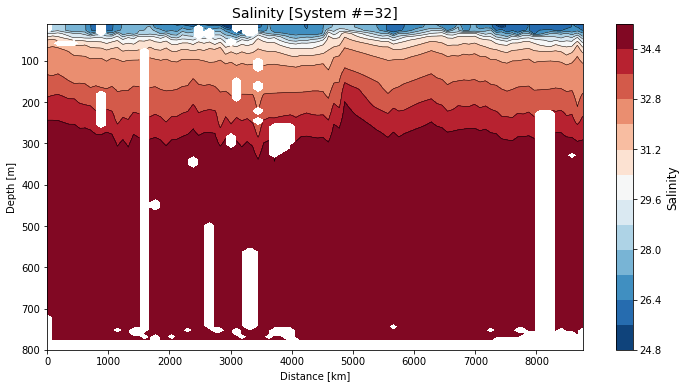

In [12]:
fig, ax1, = plt.subplots(nrows=1, figsize=(12,6))
ax1.contour(xi, yi, salt, levels=14, linewidths=0.5, colors='k')
cntr1 = ax1.contourf(xi, yi, salt, levels=14, cmap="RdBu_r")
cbar = fig.colorbar(cntr1, ax=ax1)
cbar.set_label("Salinity", fontsize=12)

ax1.set_title('Salinity [System #=%i]' % (system_nums[0]), fontsize=14)
ax1.set_xlabel("Distance [km]")
ax1.set_ylabel("Depth [m]")
plt.gca().invert_yaxis()

Draw Temperature

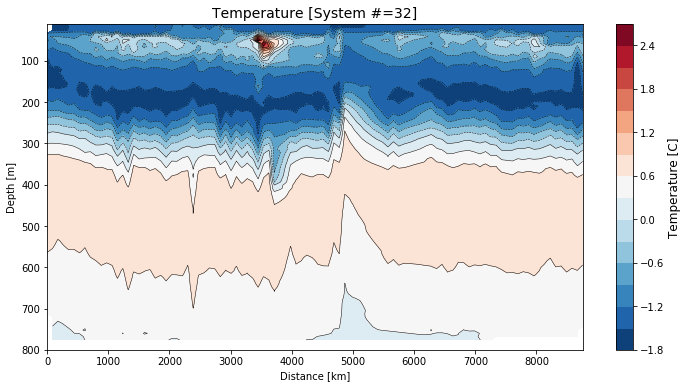

In [13]:
fig, ax1, = plt.subplots(nrows=1, figsize=(12,6))
ax1.contour(xi, yi, temp, levels=14, linewidths=0.5, colors='k')
cntr1 = ax1.contourf(xi, yi, temp, levels=14, cmap="RdBu_r")
cbar = fig.colorbar(cntr1, ax=ax1)
cbar.set_label("Temperature [C]", fontsize=12)
ax1.set_title('Temperature [System #=%i]' % (system_nums[0]), fontsize=14)
ax1.set_xlabel("Distance [km]")
ax1.set_ylabel("Depth [m]")
plt.gca().invert_yaxis()